ある電流範囲で、電圧がどのように変化するかを測定するコードのプロトタイプ。

In [ ]:
import sys
print(sys.path)

['/Users/hideto/.pyenv/versions/3.12.8/lib/python312.zip', '/Users/hideto/.pyenv/versions/3.12.8/lib/python3.12', '/Users/hideto/.pyenv/versions/3.12.8/lib/python3.12/lib-dynload', '', '/Users/hideto/ax2/.venv/lib/python3.12/site-packages']


インポートと基本設定

In [1]:
import time
# from dataclasses import dataclass
from typing import Sequence, List, Dict

import numpy as np
import pandas as pd
import pyvisa

import matplotlib.pyplot as plt

#安全のための最大電流値
Max_abs_current_A = 1e-3 # 1 mA

接続されている機器の名前とportの一覧を確認

In [2]:
# Resource Manager はvisaデバイスとの接続窓口
rm = pyvisa.ResourceManager()

print("検出されたvisaリソース一覧")
for res in rm.list_resources():
    print(" ", res)

検出されたvisaリソース一覧
  USB0::0x05E6::0x2110::1408023::INSTR
  ASRL3::INSTR
  ASRL4::INSTR
  ASRL5::INSTR
  ASRL6::INSTR
  GPIB0::18::INSTR


各機器への接続が正常にされているかの確認

In [3]:
Adress_6221 = "GPIB0::18::INSTR"
Adress_2110 = "USB0::0x05E6::0x2110::1408023::INSTR"

# resource　visa coneccitng
src_res = rm.open_resource(Adress_6221)
dmm_res = rm.open_resource(Adress_2110)

print("6221 IDN", src_res.query("*IDN?").strip())
print("2110 IDN", dmm_res.query("*IDN?").strip())

6221 IDN KEITHLEY INSTRUMENTS INC.,MODEL 6221,4521478,D04  /700x
2110 IDN KEITHLEY INSTRUMENTS INC.,MODEL 2110,1408023,01.01-00-00


電流源クラスの定義

In [4]:
class CurrentSource6221:
    def __init__(self, resource):
        self.inst = resource
        self.inst.write("SYST:REM") #念の為にリモートモードに？

    def idn(self): # IDNの応答を返す
        return self.inst.query("*IDN?").strip()
    
    def set_current(self, value_a): 
        if abs(value_a) > Max_abs_current_A:
            raise ValueError(
                f"要求された電流{value_a} A は安全上限 {Max_abs_current_A} A を超えています"
            )
        self.inst.write(f"SOUR:CURR {value_a:.6e}")

    def output_on(self):
        self.inst.write("OUTP ON")

    def output_off(self):
        self.inst.write("OUTP OFF")

    def configure_dc_current_mode(self): # set to dc current
        self.inst.write("SOUR:FUNC CURR")

    def close(self):
        try:
            self.output_off()
        except pyvisa.VisaIOError: # 【修正】全ての例外ではなく、通信エラーのみを捕捉
            pass
        self.inst.close()

電圧測定器2110の定義

In [5]:
class Voltmeter2110:
    def __init__(self, resource):
        self.inst = resource

    def idn(self):
        return self.inst.query("*IDN?").strip()
    
    def configure_dc_voltage_mode(self): # set to voltage measurement mode
        self.inst.write("CONF:VOLT:DC")

    def measure_voltage(self): # voltage measurement and return value
        resp = self.inst.query("MEAS:VOLT:DC?")
        return float(resp)
    
    def close(self):
        self.inst.close()

測定の設定を行う部分

In [6]:
class IVMeasurementConfig:
    def __init__(self, current_a, delay_s, num_averages=1):
        self.current_a = current_a
        self.delay_s = delay_s
        self.num_averages = num_averages

測定ロジックを定義するクラス

In [7]:
class IVMeasurement:
    def __init__(self, source, meter, config):
        self.source = source
        self.meter = meter
        self.config = config

    def run(self):
        records = []

        self.source.configure_dc_current_mode()
        self.meter.configure_dc_voltage_mode()

        self.source.output_on()

        try:
            for current in self.config.current_a:

                self.source.set_current(current)

                time.sleep(self.config.delay_s)

                volt_list = []
                for _ in range(self.config.num_averages):
                    v = self.meter.measure_voltage()
                    volt_list.append(v)

                v_mean = float(np.mean(volt_list))

                records.append(
                    {
                        "current_A": float(current),
                        "voltage_V": v_mean,
                    }
                )
        
        finally:
            self.source.output_off()

        df = pd.DataFrame(records)
        return df



測定条件を作って実行する

In [8]:
# 電流計と電圧計のインスタンス
source = CurrentSource6221(src_res)
meter = Voltmeter2110(dmm_res)

current = np.linspace(-100e-6, 100e-6, 11)

config = IVMeasurementConfig(
    current_a = current,
    delay_s = 0.1,
    num_averages = 3,
)

iv = IVMeasurement(source, meter, config)

print("IV測定を開始します")
df_iv = iv.run()

display(df_iv.head())

source.close()
meter.close()

IV測定を開始します


,current_A,voltage_V
0,-0.00010,0.000027
1,-0.00008,0.000085
2,-0.00006,-0.000042
3,-0.00004,0.000070
4,-0.00002,0.000076


結果を保存、プロット

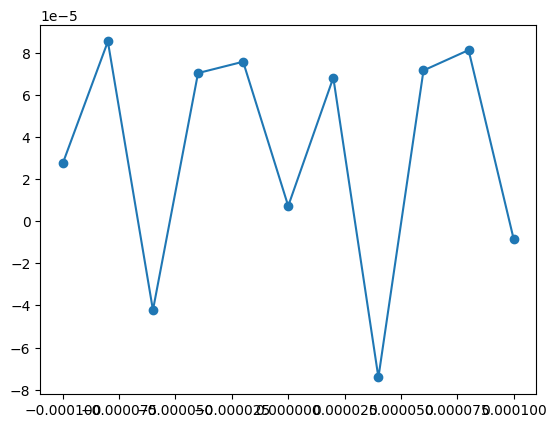

In [ ]:
# df_iv.to_csv("iv_result.csv", index=False)

plt.figure()
plt.plot(df_iv["current_A"], df_iv["voltage_V"], marker="o")
plt.show()